# Sparse PCA Simulation

Let $$S_{p\times p}=\alpha[1\ \cdots\ 1\ 0\ \cdots\ 0]^T[1\ \cdots\ 1\ 0\ \cdots\ 0] + \beta I_p$$ and $$(Z_{n\times p})_{i, j}\sim\mathcal{N}(0, 1).$$
We define $$X_{n,p}\equiv Z_{n,p}S_{p,p}.$$

In [201]:
import numpy as np
import torch
import random
from matplotlib import pyplot as plt

In [202]:
p = 50
n = 30
alpha = 0.8
beta = 0.2
sparsity = 0.3
sparse_vector = np.empty((p, 1))
for i in range(p):
    if i < p * sparsity:
        sparse_vector[i][0] = 1
    else:
        sparse_vector[i][0] = 0
S = alpha * sparse_vector @ sparse_vector.T + beta * np.identity(p)

Z = np.empty((n, p))
for i in range(n):
    for j in range(p):
        Z[i][j] = np.random.normal(0, 1)
        
X = Z @ S

sparse_vector = torch.from_numpy(sparse_vector)
S, Z, X = torch.from_numpy(S), torch.from_numpy(Z), torch.from_numpy(X)

In [203]:
S.shape, Z.shape, X.shape

(torch.Size([50, 50]), torch.Size([30, 50]), torch.Size([30, 50]))

## Method 1
We want to find $(u, v, w)$ such that 
#### $$(u, v, w)=\underset{(u, v, w)}{\text{argmin}}\ \lVert X-u(v\odot w)^T\rVert_F^2$$
where for any matrix $A$, 
#### $$\lVert A\rVert_F^2 = \sum_{i,j}A_{i,j}^2.$$

In [204]:
u = torch.randn(n, 1, requires_grad=True)
v = torch.randn(p, 1, requires_grad=True)
w = torch.randn(p, 1, requires_grad=True)

In [205]:
def objective_function_1(u, v, w):
    A = X - u @ (v * w).T
    return torch.sum(A * A)

In [206]:
epochs = 10000
step_size = 1e-4
sine_errors = []
l1 = []
iterations = [*range(epochs + 1)]
recovered = v.clone().detach() * w.clone().detach()
cosine_error = torch.sum(recovered * sparse_vector) / (torch.norm(recovered) * torch.norm(sparse_vector))
sine_error = (1 - cosine_error ** 2) ** 0.5
sine_errors.append(sine_error)
l1.append(float(torch.linalg.norm(recovered, ord=1)))
for i in range(epochs):
    objective = objective_function_1(u, v, w)
    if i % 100 == 0:
        print('Epoch ' + str(i) + ": loss = " + str(float(objective)))
    objective.backward()
    with torch.no_grad():
        u -= u.grad * step_size
        v -= v.grad * step_size
        w -= w.grad * step_size
        u.grad.zero_()
        v.grad.zero_()
        w.grad.zero_()
    recovered = v.clone().detach() * w.clone().detach()
    cosine_error = torch.sum(recovered * sparse_vector) / (torch.norm(recovered) * torch.norm(sparse_vector))
    sine_error = (1 - cosine_error ** 2) ** 0.5
    sine_errors.append(sine_error)
    l1.append(float(torch.linalg.norm(recovered, ord=1)))
    v.grad.zero_()
    w.grad.zero_()
print('Epoch ' + str(epochs) + ": loss = " + str(float(objective_function_1(u, v, w))))

Epoch 0: loss = 5302.7955815796795
Epoch 100: loss = 4345.751098778467
Epoch 200: loss = 2119.1344727803335
Epoch 300: loss = 99.79964073941285
Epoch 400: loss = 64.44446963966078
Epoch 500: loss = 59.0776016014549
Epoch 600: loss = 57.16095777115828
Epoch 700: loss = 56.28330184460241
Epoch 800: loss = 55.81359092025324
Epoch 900: loss = 55.536167063761646
Epoch 1000: loss = 55.361693334388775
Epoch 1100: loss = 55.24725805493027
Epoch 1200: loss = 55.16989911936298
Epoch 1300: loss = 55.116369142930935
Epoch 1400: loss = 55.07860552936142
Epoch 1500: loss = 55.05150919733387
Epoch 1600: loss = 55.03177635885785
Epoch 1700: loss = 55.017196121662074
Epoch 1800: loss = 55.006281213639916
Epoch 1900: loss = 54.998001769234634
Epoch 2000: loss = 54.991643885818206
Epoch 2100: loss = 54.986699944680886
Epoch 2200: loss = 54.982808891311564
Epoch 2300: loss = 54.979710999609345
Epoch 2400: loss = 54.97721796148814
Epoch 2500: loss = 54.975186358938075
Epoch 2600: loss = 54.973513779412144


In [ ]:
print(v * w)

In [ ]:
plt.plot(iterations, sine_errors, label="sine_error")
plt.plot(iterations, l1, label="l1 norm")
plt.show()

In [ ]:
plt.plot(iterations, sine_errors)
plt.show()

## Method 2
We want to find $(u, v, w)$ such that 
#### $$(u, v, w)=\underset{(u, v, w)}{\text{argmin}}\ \lVert X-Xu(v\odot w)^T\rVert_F^2.$$

In [ ]:
u = torch.randn(p, 1, requires_grad=True)
v = torch.randn(p, 1, requires_grad=True)
w = torch.randn(p, 1, requires_grad=True)

In [ ]:
def objective_function_2(u, v, w):
    A = X - (X.double() @ u.double()).double() @ (v * w).T.double()
    return torch.sum(A * A)

In [ ]:
epochs = 100000
step_size = 5e-7
sine_errors = []
l1 = []
iterations = [*range(epochs + 1)]
recovered = v.clone().detach() * w.clone().detach()
cosine_error = torch.sum(recovered * sparse_vector) / (torch.norm(recovered) * torch.norm(sparse_vector))
sine_error = (1 - cosine_error ** 2) ** 0.5
sine_errors.append(sine_error)
l1.append(float(torch.linalg.norm(recovered, ord=1)))
for i in range(epochs):
    objective = objective_function_2(u, v, w)
    if i % 1000 == 0:
        print('Epoch ' + str(i) + ": loss = " + str(float(objective)))
    objective.backward()
    with torch.no_grad():
        u -= u.grad * step_size
        v -= v.grad * step_size
        w -= w.grad * step_size
        u.grad.zero_()
        v.grad.zero_()
        w.grad.zero_()
    recovered = v.clone().detach() * w.clone().detach()
    cosine_error = torch.sum(recovered * sparse_vector) / (torch.norm(recovered) * torch.norm(sparse_vector))
    sine_error = (1 - cosine_error ** 2) ** 0.5
    sine_errors.append(sine_error)
    l1.append(float(torch.linalg.norm(recovered, ord=1)))
print('Epoch ' + str(epochs) + ": loss = " + str(float(objective_function_2(u, v, w))))

In [ ]:
print(v * w)

In [ ]:
plt.plot(iterations, sine_errors, label="sine_errors")
plt.plot(iterations, l1, label="l1")
plt.show()

In [ ]:
plt.plot(iterations, sine_errors)
plt.show()

## Method 3
We want to find $(u, v, w)$ such that 
#### $$(u, v, w)=\underset{(u, v, w)}{\text{argmin}}\ \lVert X-u(v\odot v - w\odot w)^T\rVert_F^2.$$

In [ ]:
u = torch.randn(n, 1, requires_grad=True)
v = torch.randn(p, 1, requires_grad=True)
w = torch.randn(p, 1, requires_grad=True)

In [ ]:
def objective_function_3(u, v, w):
    A = X - u @ (v * v - w * w).T
    return torch.sum(A * A)

In [ ]:
epochs = 10000
step_size = 1e-4
sine_errors = []
l1 = []
iterations = [*range(epochs + 1)]
recovered = v.clone().detach() * v.clone().detach() - w.clone().detach() * w.clone().detach()
cosine_error = torch.sum(recovered * sparse_vector) / (torch.norm(recovered) * torch.norm(sparse_vector))
sine_error = (1 - cosine_error ** 2) ** 0.5
sine_errors.append(sine_error)
l1.append(float(torch.linalg.norm(recovered, ord=1)))
for i in range(epochs):
    objective = objective_function_3(u, v, w)
    if i % 100 == 0:
        print('Epoch ' + str(i) + ": loss = " + str(float(objective)))
    objective.backward()
    with torch.no_grad():
        u -= u.grad * step_size
        v -= v.grad * step_size
        w -= w.grad * step_size
        u.grad.zero_()
        v.grad.zero_()
        w.grad.zero_()
    recovered = v.clone().detach() * v.clone().detach() - w.clone().detach() * w.clone().detach()
    cosine_error = torch.sum(recovered * sparse_vector) / (torch.norm(recovered) * torch.norm(sparse_vector))
    sine_error = (1 - cosine_error ** 2) ** 0.5
    sine_errors.append(sine_error)
    l1.append(float(torch.linalg.norm(recovered, ord=1)))
print('Epoch ' + str(epochs) + ": loss = " + str(float(objective_function_3(u, v, w))))

In [ ]:
print(v * v - w * w)

In [ ]:
plt.plot(iterations, sine_errors, label="sine_errors")
plt.plot(iterations, l1, label="l1")
plt.show()

In [ ]:
plt.plot(iterations, sine_errors)

## Method 4
We want to find $(u, v, w)$ such that 
#### $$(u, v, w)=\underset{(u, v, w)}{\text{argmin}}\ \lVert X-Xu(v\odot v - w\odot w)^T\rVert_F^2.$$

In [ ]:
u = torch.randn(p, 1, requires_grad=True)
v = torch.randn(p, 1, requires_grad=True)
w = torch.randn(p, 1, requires_grad=True)

In [ ]:
def objective_function_4(u, v, w):
    A = X - X.double() @ u.double() @ (v * v - w * w).T.double()
    return torch.sum(A * A)

In [ ]:
epochs = 100000
step_size = 5e-7
sine_errors = []
l1 = []
iterations = [*range(epochs + 1)]
recovered = v.clone().detach() * v.clone().detach() - w.clone().detach() * w.clone().detach()
cosine_error = torch.sum(recovered * sparse_vector) / (torch.norm(recovered) * torch.norm(sparse_vector))
sine_error = (1 - cosine_error ** 2) ** 0.5
sine_errors.append(sine_error)
l1.append(float(torch.linalg.norm(recovered, ord=1)))
for i in range(epochs):
    objective = objective_function_4(u, v, w)
    if i % 1000 == 0:
        print('Epoch ' + str(i) + ": loss = " + str(float(objective)))
    objective.backward()
    with torch.no_grad():
        u -= u.grad * step_size
        v -= v.grad * step_size
        w -= w.grad * step_size
        u.grad.zero_()
        v.grad.zero_()
        w.grad.zero_()
    recovered = v.clone().detach() * v.clone().detach() - w.clone().detach() * w.clone().detach()
    cosine_error = torch.sum(recovered * sparse_vector) / (torch.norm(recovered) * torch.norm(sparse_vector))
    sine_error = (1 - cosine_error ** 2) ** 0.5
    sine_errors.append(sine_error)
    l1.append(float(torch.linalg.norm(recovered, ord=1)))
print('Epoch ' + str(epochs) + ": loss = " + str(float(objective_function_4(u, v, w))))

In [ ]:
print(v * v - w * w)

In [ ]:
plt.plot(iterations, sine_errors, label="sine_errors")
plt.plot(iterations, l1, label="l1")
plt.show()

In [ ]:
plt.plot(iterations, sine_errors)
plt.show()

### Hadamard Parametrization
We want to maximize 
#### $$(u\odot v)^TS(u\odot v)$$
where
#### $$S=\frac{1}{n}X^TX$$
under the constraint
#### $$\lVert u\odot v\rVert = 1$$

In [218]:
u = torch.randn(p, 1)
v = torch.randn(p, 1)
norm = torch.norm(u * v)
u = u / (norm ** 0.5)
v = v / (norm ** 0.5)

In [219]:
epochs = 200000
step_size = 1e-5
sine_errors = []
l1 = []
iterations = [*range(epochs + 1)]
recovered = u.clone().detach() * v.clone().detach()
cosine_error = torch.sum(recovered * sparse_vector) / (torch.norm(recovered) * torch.norm(sparse_vector))
sine_error = (1 - cosine_error ** 2) ** 0.5
sine_errors.append(sine_error)
l1.append(float(torch.linalg.norm(recovered, ord=1)))
for i in range(epochs):
    if i % 1000 == 0:
        objective = ((u * v).T.double() @ S.double() @ (u * v).double())[0][0]
        print('Epoch ' + str(i) + ": objective = " + str(float(objective)))
    du = v.double() * ((S + S.T).double() @ (u * v).double())
    dv = u.double() * ((S + S.T).double() @ (u * v).double())
    u += du * step_size
    v += dv * step_size
    norm = torch.norm(u * v)
    u = u / (norm ** 0.5)
    v = v / (norm ** 0.5)
    recovered = u.clone().detach() * v.clone().detach()
    cosine_error = torch.sum(recovered * sparse_vector) / (torch.norm(recovered) * torch.norm(sparse_vector))
    sine_error = (1 - cosine_error ** 2) ** 0.5
    sine_errors.append(sine_error)
    l1.append(float(torch.linalg.norm(recovered, ord=1)))
objective = ((u * v).T.double() @ S.double() @ (u * v).double())[0][0]
print('Epoch ' + str(epochs) + ": objective = " + str(float(objective)))

Epoch 0: objective = 0.21252192271924175
Epoch 1000: objective = 0.21415363473423596
Epoch 2000: objective = 0.21598963375910507
Epoch 3000: objective = 0.2180596089929115
Epoch 4000: objective = 0.22039007150714
Epoch 5000: objective = 0.22300943940238266
Epoch 6000: objective = 0.22596068717549275
Epoch 7000: objective = 0.22928409102906133
Epoch 8000: objective = 0.23302572211902828
Epoch 9000: objective = 0.2372327399635619
Epoch 10000: objective = 0.24195266632374707
Epoch 11000: objective = 0.2472527600528679
Epoch 12000: objective = 0.25320687807877207
Epoch 13000: objective = 0.2598909998167695
Epoch 14000: objective = 0.26737318219238493
Epoch 15000: objective = 0.27575577369355264
Epoch 16000: objective = 0.28515352598289284
Epoch 17000: objective = 0.2956746155243446
Epoch 18000: objective = 0.3074283018461026
Epoch 19000: objective = 0.32054743092435223
Epoch 20000: objective = 0.33519488746969434
Epoch 21000: objective = 0.35153902288323297
Epoch 22000: objective = 0.36975

Epoch 186000: objective = 3.3688609747544316
Epoch 187000: objective = 3.364705276119045
Epoch 188000: objective = 3.360534770006076
Epoch 189000: objective = 3.356336355469059
Epoch 190000: objective = 3.352204213283349
Epoch 191000: objective = 3.3481255705332824
Epoch 192000: objective = 3.3440194278026594
Epoch 193000: objective = 3.3398976566728
Epoch 194000: objective = 3.3357925442133367
Epoch 195000: objective = 3.3316802985649665
Epoch 196000: objective = 3.327534814222428
Epoch 197000: objective = 3.3233913512968978
Epoch 198000: objective = 3.319248717061306
Epoch 199000: objective = 3.3151910651880954
Epoch 200000: objective = 3.3111555072380363


In [220]:
print(u * v)

tensor([[-6.6802e-01],
        [-1.9822e-02],
        [-5.2299e-04],
        [-4.1330e-01],
        [-1.5447e-06],
        [-2.9407e-02],
        [-6.6917e-03],
        [-3.6264e-03],
        [-8.4815e-04],
        [-6.0737e-02],
        [-6.0221e-01],
        [-1.1300e-04],
        [-1.9517e-02],
        [-2.8607e-02],
        [-1.1861e-01],
        [ 3.2946e-09],
        [-6.1876e-07],
        [-1.8428e-06],
        [ 1.5761e-06],
        [-1.5614e-06],
        [ 7.8108e-07],
        [ 1.5161e-06],
        [-1.6455e-06],
        [-2.3076e-06],
        [ 1.1742e-06],
        [-6.2080e-07],
        [-1.9875e-06],
        [-6.4834e-07],
        [-5.1020e-06],
        [-3.4240e-06],
        [-4.5416e-06],
        [-1.1492e-09],
        [-9.8194e-07],
        [ 3.6483e-06],
        [-6.0050e-07],
        [-9.0552e-07],
        [ 1.5439e-07],
        [ 4.4301e-07],
        [-1.1754e-07],
        [ 1.9568e-06],
        [-4.5271e-07],
        [ 1.4156e-05],
        [-4.1478e-06],
        [ 2

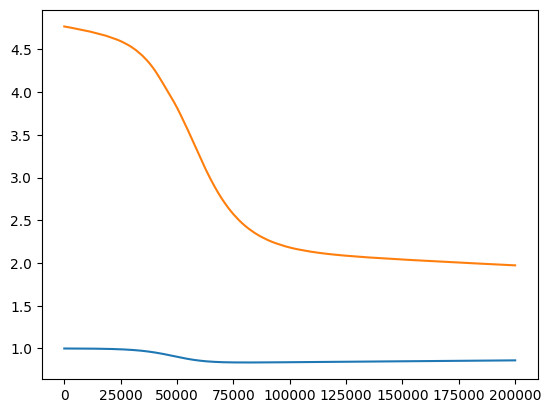

In [221]:
plt.plot(iterations, sine_errors, label="sine_errors")
plt.plot(iterations, l1, label="l1")
plt.show()

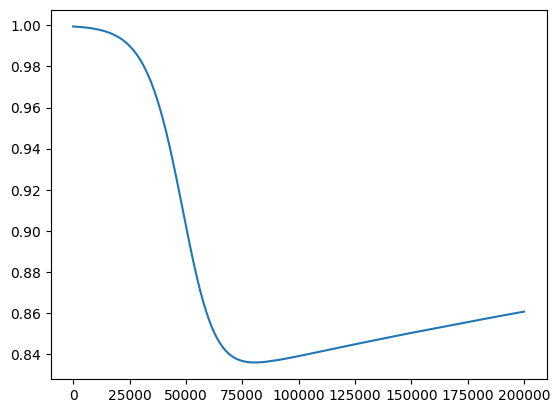

In [222]:
plt.plot(iterations, sine_errors)
plt.show()